# Cibersortx 下流解析用#  
注意点:  
- それぞれの図が勝手に保存されるので、操作によっては誤って上書きされる可能性があります。
- seabornをインポートして、もう少し綺麗な色に変えられます（さぼっています…）。

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 関数　##  

In [47]:
def my_barplot(df, fig_name):
    plt.figure()
    df[celltypes].plot.bar(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.savefig(fig_name)
    plt.show()
    plt.close('all')

In [48]:
def my_filter(df, first_item, second_item, c1, c2,comments):
    df = df[df[first_item] >= c1]
    df = df[df[second_item] >= c2]
    if df.empty == True: 
        if comments == True:
            print('Sorted by '+first_item+' cell fractions (>='+str(c1)+'), then by '+second_item+' cell fractions (>='+str(c2)+')')
            print('\tNull!')
    else:
        print('Sorted by '+first_item+' cell fractions (>='+str(c1)+'), then by '+second_item+' cell fractions (>='+str(c2)+')')
        my_barplot(df.sort_values(by =[first_item,second_item] , ascending=False), plot_path+'/barplot_filtered_sorted_by_'+first_item+'_'+second_item+'.png')
    return

## 本体　##

#### データ読み込みと、概観確認 ####
Cibersortxの出力ファイルを変えるとき（肝臓→腎臓など）は、次のセルを編集する。

In [49]:
filename_fractions = 'CIBERSORTx_Job19_Results.txt'

In [50]:
# import data
df_fractions = pd.read_csv(filename_fractions,sep='\t',index_col=0)

In [51]:
#図を保存したい先のフォルダ
plot_path = './plots'

データの概観を見てみる。

In [52]:
df_fractions.head()

,B,Hepato,Kuppfer,T,Epi,DC,Macro,Endo,Gran,Eryth,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,,,
AAAAATCCATTA,0.000000,0.407224,0.401604,0.182692,0.008480,0.0,0.0,0.0,0.000000,0.000000,0,0.329058,0.948825
AAAAATCCATTC,0.004412,0.262714,0.000000,0.000000,0.164082,0.0,0.0,0.0,0.049535,0.519257,0,0.065647,1.079151
AAAAATTGCGGG,0.000000,0.305348,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.694652,0,0.204384,1.019187
AAAACAAGAGAA,0.000233,0.820460,0.114703,0.000000,0.064603,0.0,0.0,0.0,0.000000,0.000000,0,0.494806,0.899540
AAAACACACGAA,0.000000,0.789404,0.210596,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0.469982,0.911347


In [53]:
celltypes = [item for item in df_fractions.columns.values if item not in ['P-value', 'Correlation', 'RMSE']]
print('The cell types in this dataset:',celltypes)
print('Total of ',str(len(celltypes)),' cell types')

The cell types in this dataset: ['B', 'Hepato', 'Kuppfer', 'T', 'Epi', 'DC', 'Macro', 'Endo', 'Gran', 'Eryth']
Total of  10  cell types


とりあえず、プロットしてみる。

<Figure size 432x288 with 0 Axes>

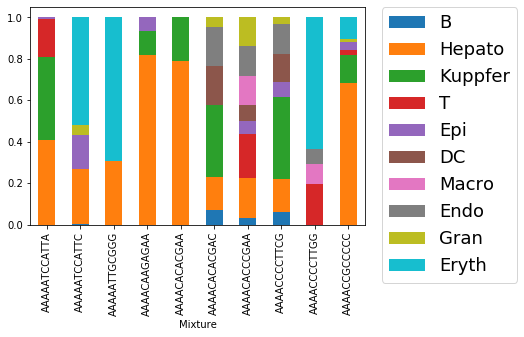

In [54]:
my_barplot(df_fractions,plot_path+'/barplot_all_fractions.png')

#### ソート ####
ある値に着目してソートする。 
**次の次のセルに入力**する。（ちなみに指定可能なラベルは下に表示される通り）    
例：RMSE (説明できなかった誤差) でソートした上で、プロット。

In [55]:
print(df_fractions.columns.values)

['B' 'Hepato' 'Kuppfer' 'T' 'Epi' 'DC' 'Macro' 'Endo' 'Gran' 'Eryth'
 'P-value' 'Correlation' 'RMSE']


In [56]:
##ここに入力
val = 'RMSE'

Sorted by RMSE


<Figure size 432x288 with 0 Axes>

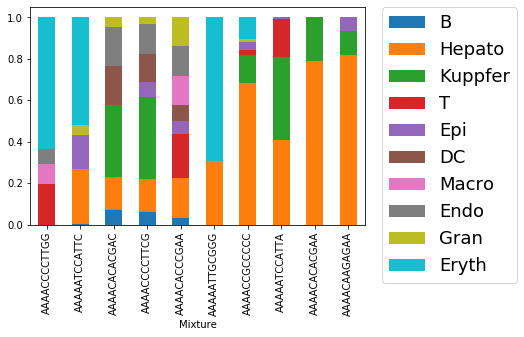

In [57]:
print('Sorted by '+val)
my_barplot(df_fractions.sort_values(by =[val] , ascending=False), plot_path+'/barplot_sorted_by_'+val+'.png')

細胞種Aの割合が多い順にバルクをソートして、次に細胞種Bの割合が多い順にソートする。

Sorted by B cell fractions, then by Hepato cell fractions


<Figure size 432x288 with 0 Axes>

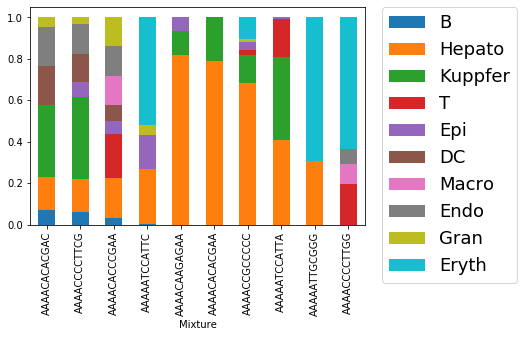

In [59]:
#breakをコメントアウトして使う
for first_item in celltypes:
    #全細胞種の組み合わせを走査する。
    for second_item in celltypes:
        if first_item == second_item:
            continue
        print('Sorted by '+first_item+' cell fractions, then by '+second_item+' cell fractions')
        my_barplot(df_fractions.sort_values(by =[first_item,second_item] , ascending=False), plot_path+'/barplot_sorted_by_'+first_item+'_'+second_item+'.png')
        break
    break

#### フィルターをかけたソート ####
2種の細胞種がある程度の割合ずつ（下記のデフォルトでは40%ずつ）いるようなバルクを図示したい。

In [60]:
#ここで'ある程度の割合い'を指定

#cut off value for first cell type
c1 = 0.2 
#cut off value for second cell type
c2 = 0.1

#もし、与えた基準に合うバルクが一個もなかった時に、その旨を出力してほしければ、下記をTrueにする。
comments = False

Sorted by Hepato cell fractions (>=0.2), then by Kuppfer cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

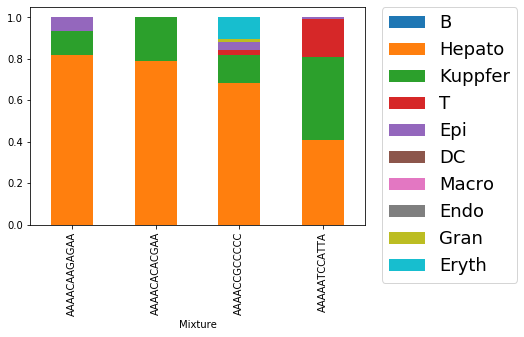

Sorted by Hepato cell fractions (>=0.2), then by T cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

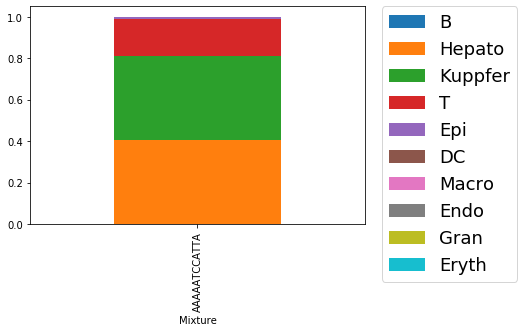

Sorted by Hepato cell fractions (>=0.2), then by Epi cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

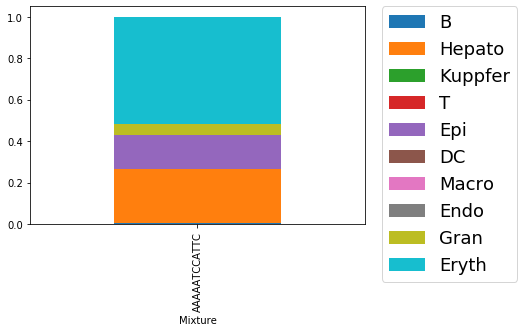

Sorted by Hepato cell fractions (>=0.2), then by Eryth cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

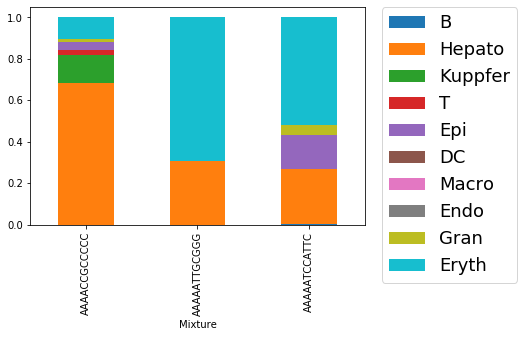

Sorted by Kuppfer cell fractions (>=0.2), then by Hepato cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

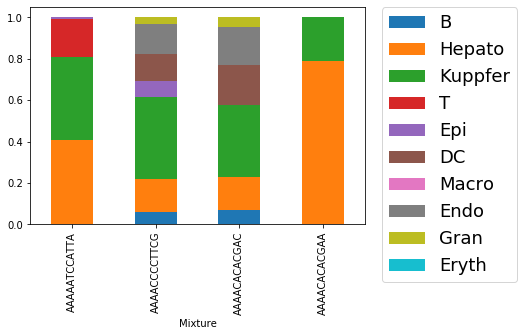

Sorted by Kuppfer cell fractions (>=0.2), then by T cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

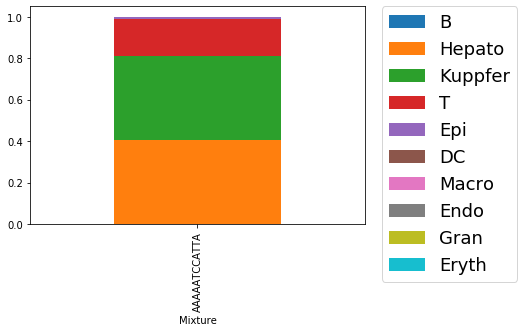

Sorted by Kuppfer cell fractions (>=0.2), then by DC cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

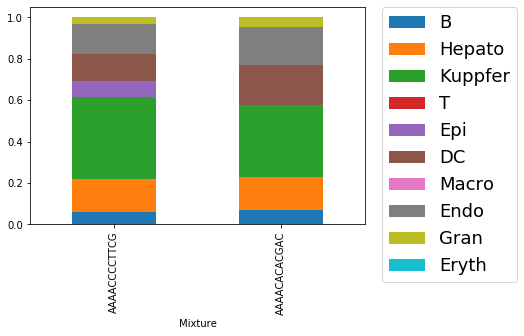

Sorted by Kuppfer cell fractions (>=0.2), then by Endo cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

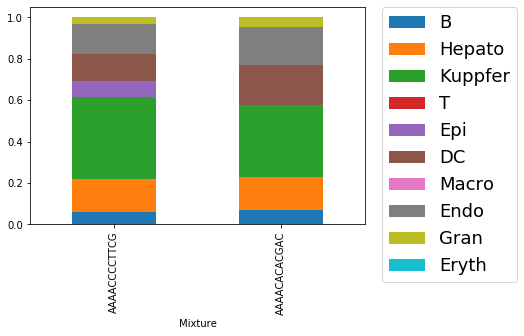

Sorted by T cell fractions (>=0.2), then by Hepato cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

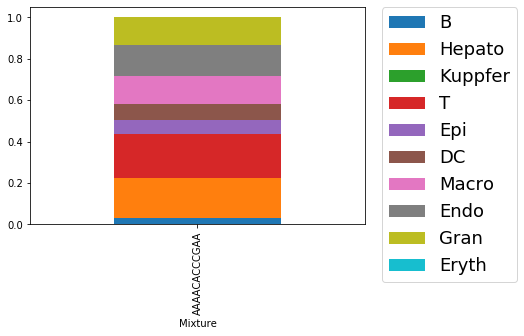

Sorted by T cell fractions (>=0.2), then by Macro cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

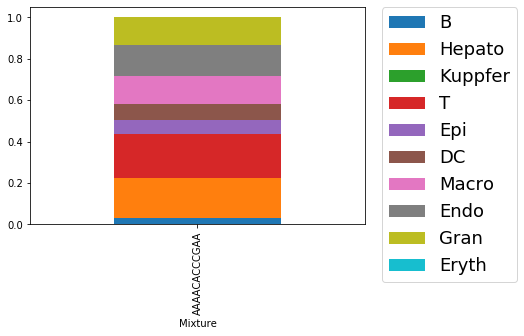

Sorted by T cell fractions (>=0.2), then by Endo cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

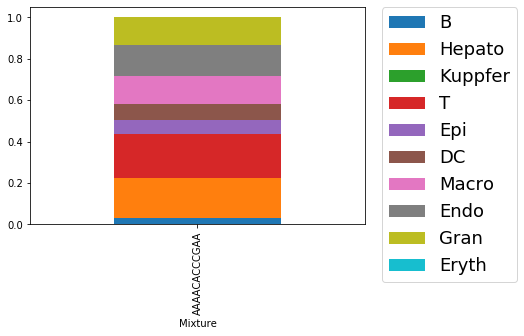

Sorted by T cell fractions (>=0.2), then by Gran cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

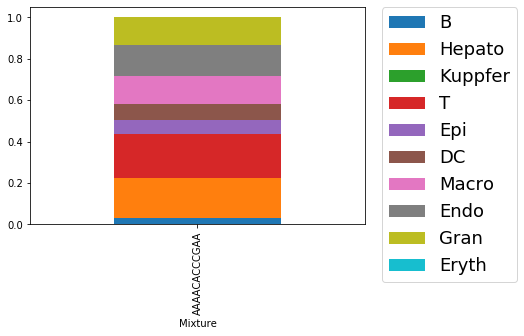

Sorted by Eryth cell fractions (>=0.2), then by Hepato cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

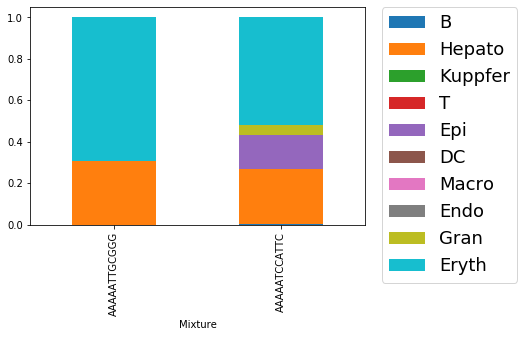

Sorted by Eryth cell fractions (>=0.2), then by T cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

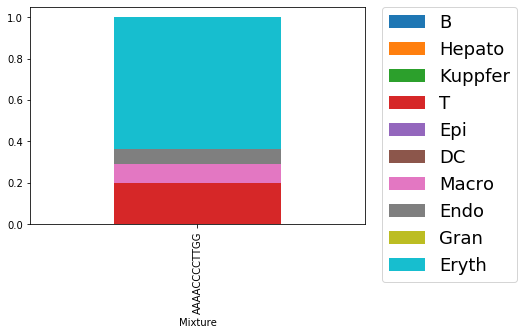

Sorted by Eryth cell fractions (>=0.2), then by Epi cell fractions (>=0.1)


<Figure size 432x288 with 0 Axes>

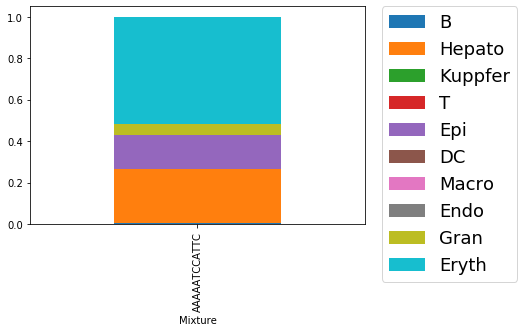

In [61]:
#breakをコメントアウトして使う
for first_item in celltypes:
    #全細胞種の組み合わせを走査する。
    for second_item in celltypes:
        if first_item == second_item:
            continue
        my_filter(df_fractions, first_item, second_item, c1, c2,comments)
        #break
    #break

網羅的に図を生成するのではなくて、各々の細胞種でcut off値を設定したいときは下のセルの、引数を調整

In [62]:
first_celltype = 'B'
second_celltype = 'Hepato'
cutoff1 = 0.02
cutoff2 = 0.01

my_filter(df_fractions, first_celltype, second_celltype, cutoff1, cutoff2)

TypeError: my_filter() missing 1 required positional argument: 'comments'